In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("../details/total_ped_matrix.npy")

with open("../details/ped_dataset.pkl", "rb") as f:
    ped_dataset = pickle.load(f)
    
with open('../details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../../data/', \
                verbose=False)

In [4]:
so_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [5]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [3]:
# train_test split

x_train = total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :]
x_train = x_train.reshape(TRAIN_SIZE, 42)
y_train = total_ped_matrix[:TRAIN_SIZE, TRAIN_TIME:, :2]

x_test = total_ped_matrix[TRAIN_SIZE:, :TRAIN_TIME, :]
x_test = x_test.reshape(len(total_ped_matrix)-TRAIN_SIZE, 42)
y_test = total_ped_matrix[TRAIN_SIZE:, TRAIN_TIME:, :2]

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [5]:
# defining the custom rmse loss function
def rmse_loss(gt, pred):
    '''
    calculates custom rmse loss between every time point
    '''
    pred_path = pred[:,:20]
    pred_path = tf.reshape(pred_path, [-1,10,2])
    gt = tf.reshape(gt, [-1,10,2])
    
    print(gt.shape)
    print(pred_path.shape)
    
    l2_x = K.square(gt[:,:,0] - pred_path[:,:,0])
    l2_y = K.square(gt[:,:,1] - pred_path[:,:,1])
    
    pred_sigma = pred[:,20:]
    pred_sigma = tf.reshape(pred_sigma, [-1,10,2])
    
    # log(sigma)
    logs_x = pred_sigma[:,:,0] * 0.5 
    logs_y = pred_sigma[:,:,1] * 0.5
    
    # sigma^2
    s_x = K.exp(pred_sigma[:,:,0])
    s_y = K.exp(pred_sigma[:,:,1])
    
    r = (l2_x/(2*s_x)) + (l2_y/(2*s_y))
    return K.mean(r) + logs_x + logs_y

In [6]:
# defining the model
traj_input = Input(shape=(x_train.shape[1]))

x = Dense(32, activation='relu')(traj_input)

x_reg = Dense(20, activation='linear')(x)
x_sig = Dense(20, activation='tanh')(x)

combined_output = concatenate([x_reg, x_sig], axis=-1)
umlp_model = Model(inputs=[traj_input], outputs=[combined_output])

umlp_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                       loss=rmse_loss, metrics=["accuracy"])

(None, 10, 2)
(None, 10, 2)


In [7]:
umlp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1376        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           660         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           660         dense[0][0]                      
______________________________________________________________________________________________

In [9]:
# checkpoint for saving the best model
filepath="../checkpoints/uncertain_mlp_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, 
                                                save_weights_only=False,
                                                mode='max')
callbacks_list = [checkpoint]

train_history = umlp_model.fit(train_data, epochs=20,
                             verbose=0, callbacks=callbacks_list,
#                              validation_data=val_data,
                             steps_per_epoch=400,
#                              validation_steps=60
                             )

InvalidArgumentError:  Incompatible shapes: [32,10] vs. [32]
	 [[node metrics/accuracy/Equal (defined at <ipython-input-8-268af7ec93c7>:13) ]] [Op:__inference_distributed_function_970]

Function call stack:
distributed_function


In [24]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

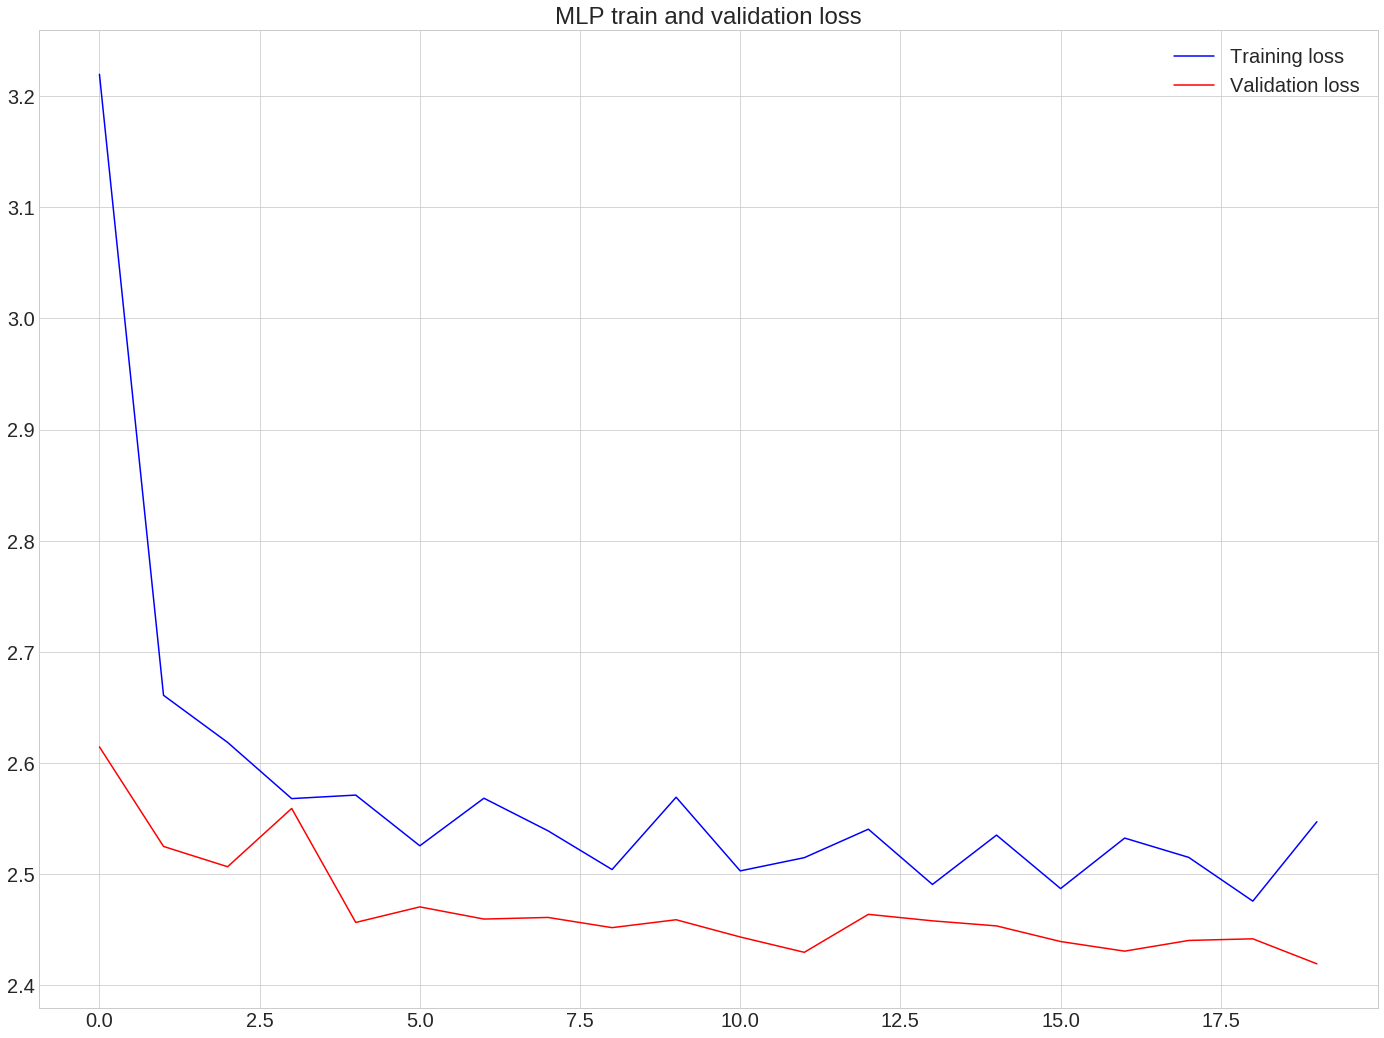

In [25]:
plot_train_history(train_history, "MLP train and validation loss")

In [26]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1))) 

In [29]:
for test_idx in range(TRAIN_SIZE, TRAIN_SIZE+2):
    test_data = np.reshape(total_ped_matrix[test_idx,:6,:]
                           , (1, 42))
    predictions = umlp_model.predict(test_data)[:,:,:2].reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])
    print(predictions)

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss = rmse_error(predictions, np.array(ped_dataset[test_idx]["translation"])[6:,:2])
        
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
    print(f"Loss in m is {loss}")
    print(f"Loss of final position in m is {final_loss}")

[[1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272], [1289.6727660653341, 1026.4773933789272]]
Loss in m is 1.957545920674724
Loss of final position in m is 3.4463254141125446
[[1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948], [1283.4833147500742, 1019.4840428352948]]
Loss in m is 1.8977246899194231
Loss of final position in m is 3.223732341073